In [187]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
#veriyi eğitim ve test seti olarak ayırmak için train_test_split
#modelin parametrelerinin kombinasyonlarından en iyi sonucu bulabilme işlemi için GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV 

#verileri standardize edip ölçeklendirme için StandardScaler. farklı özelliklerin değerleri arasındaki farkı azaltıp tüm veiriy aynı ölçeğe getirir
from sklearn.preprocessing import StandardScaler, LabelEncoder

#principal component analysis (PCA), veri setindeki boyutlatı en önemli özellikleri seçerek azaltmaya yarar
from sklearn.decomposition import PCA

# support vector machine
from sklearn.svm import SVC

#birçok model tahmininin oy birliği ile karara vardığı yöntem VotingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#verileri en yakın komşularına göre sınıflandırır
from sklearn.neighbors import KNeighborsClassifier

#modelin doğruluğunu konfüzyon matrisinde değerlendirir, display ise matrisi görselleştirme aracıdır
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [188]:
#load digits fonksiyonu el yazısı rakamlar içeren bir veri setini yükler, bu veri setini modelimizi eğitmede kullanacağız.
digits = load_digits()

# data, feature ları içerir. target ise labelları içerir. x girdileri y çıktıları temsil eder
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#veriyi standardize etmek için standart scaler nesnesi oluşturulur. bu nesne veriyi ortalama 0 standart sapması 1 olacak şekilde ölçeklendirir
scaler = StandardScaler()
#eğitim verisinin fit (uyum sağlama) işlemi yapılır ve aynı zamanda veriler dönüştürülür. verilerin ölçeklendirilmesi işlemini gerçekleştirir
X_train_scaled = scaler.fit_transform(X_train)
#test verisini sadece dönüştürür ancak eğitim verisindeki bilgiye dayalı olarak yapılır. 
# bu sayede eğitim ve test verisi aynı ölçekleme işlemin etabi tutulur
X_test_scaled = scaler.transform(X_test)

In [189]:
df = pd.read_csv("used_dataset.csv")
# DataFrame'in veri tiplerini yazdırmak
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       8763 non-null   int64  
 1   Cholesterol               8763 non-null   int64  
 2   Diabetes                  8763 non-null   int64  
 3   Obesity                   8763 non-null   int64  
 4   Alcohol Consumption       8763 non-null   int64  
 5   Exercise Hours Per Week   8763 non-null   float64
 6   Income                    8763 non-null   int64  
 7   Triglycerides             8763 non-null   int64  
 8   Sleep Hours Per Day       8763 non-null   int64  
 9   Hemisphere                8763 non-null   int64  
 10  Systolic Blood Pressure   8763 non-null   int64  
 11  Diastolic Blood Pressure  8763 non-null   int64  
 12  Heart Attack Risk         8763 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 890.1 KB
None


Outlier detection

In [190]:
X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

In [191]:
#IQR yöntemi kullanacağız
X.describe()

,Age,Cholesterol,Diabetes,Obesity,Alcohol Consumption,Exercise Hours Per Week,Income,Triglycerides,Sleep Hours Per Day,Hemisphere,Systolic Blood Pressure,Diastolic Blood Pressure
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,259.877211,0.652288,0.501426,0.598083,10.014284,158263.181901,417.677051,7.023508,0.645898,135.075659,85.156111
std,21.249509,80.863276,0.476271,0.500026,0.490313,5.783745,80575.190806,223.748137,1.988473,0.478268,26.349976,14.676565
min,18.000000,120.000000,0.000000,0.000000,0.000000,0.002442,20062.000000,30.000000,4.000000,0.000000,90.000000,60.000000
25%,35.000000,192.000000,0.000000,0.000000,0.000000,4.981579,88310.000000,225.500000,5.000000,0.000000,112.000000,72.000000
50%,54.000000,259.000000,1.000000,1.000000,1.000000,10.069559,157866.000000,417.000000,7.000000,1.000000,135.000000,85.000000
75%,72.000000,330.000000,1.000000,1.000000,1.000000,15.050018,227749.000000,612.000000,9.000000,1.000000,158.000000,98.000000
max,90.000000,400.000000,1.000000,1.000000,1.000000,19.998709,299954.000000,800.000000,10.000000,1.000000,180.000000,110.000000


In [192]:
for i in df.columns:
    Q1 = np.percentile(df[i].dropna(), 25)  # Eksik verileri kaldırarak işlem yap
    Q3 = np.percentile(df[i].dropna(), 75)
    IQR = Q3 - Q1

    print(f"old shape: {df.shape}")

    # Üst ve alt sınırları hesaplayarak aykırı değerleri kaldır
    upper = np.where(df[i] > (Q3 + 1.5 * IQR))
    lower = np.where(df[i] < (Q1 - 1.5 * IQR))

    # Üst sınırları kaldır
    df.drop(upper[0], inplace=True)
    # Alt sınırları kaldır
    df.drop(lower[0], inplace=True)

    # İndeksleri sıfırla
    df.reset_index(drop=True, inplace=True)

    print(f"new shape: {df.shape}")


old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)
old shape: (8763, 13)
new shape: (8763, 13)


# Modelling

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       8763 non-null   int64  
 1   Cholesterol               8763 non-null   int64  
 2   Diabetes                  8763 non-null   int64  
 3   Obesity                   8763 non-null   int64  
 4   Alcohol Consumption       8763 non-null   int64  
 5   Exercise Hours Per Week   8763 non-null   float64
 6   Income                    8763 non-null   int64  
 7   Triglycerides             8763 non-null   int64  
 8   Sleep Hours Per Day       8763 non-null   int64  
 9   Hemisphere                8763 non-null   int64  
 10  Systolic Blood Pressure   8763 non-null   int64  
 11  Diastolic Blood Pressure  8763 non-null   int64  
 12  Heart Attack Risk         8763 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 890.1 KB


In [194]:
X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

In [195]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [196]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_prob = logreg.predict_proba(X_test)

y_pred_prob


array([[0.65424094, 0.34575906],
       [0.5822397 , 0.4177603 ],
       [0.64279425, 0.35720575],
       ...,
       [0.64647028, 0.35352972],
       [0.68051424, 0.31948576],
       [0.61734704, 0.38265296]], shape=(1753, 2))

In [197]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred
print(f"test accurary: {accuracy_score(y_test, y_pred)}")

test accurary: 0.6417569880205363


<function matplotlib.pyplot.show(close=None, block=None)>

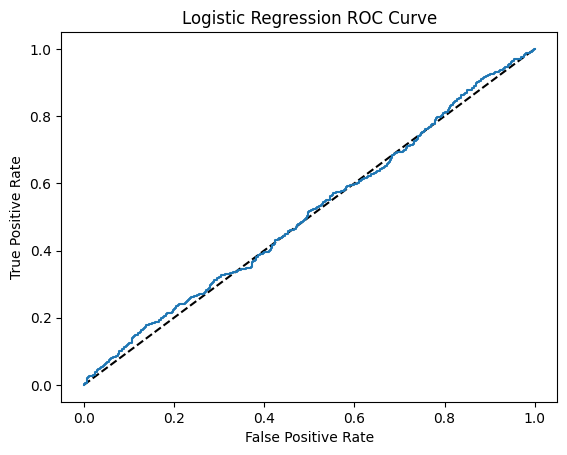

In [198]:
#roc curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])

#plot curve
plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label = "Logistic Regression")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show

In [204]:
# hyperparameter tuning
lr = LogisticRegression()
penalty = ['l1', 'l2']  
parameters = {"penalty": penalty}

lr_searcher = GridSearchCV(lr, parameters)
lr_searcher.fit(X_train, y_train)

print(f"Best parameters: {lr_searcher.best_params_}")
y_pred = lr_searcher.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")

Best parameters: {'penalty': 'l2'}
Test accuracy: 0.6417569880205363


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L